## Building an Agent around a Query Pipeline with a ReAct dynamic top k tool


In this tutorial, we demonstrate how to construct an agent that operates around a query pipeline, incorporating a dynamic top-k based on a React agent. Agents are designed to facilitate complex, sequential reasoning over any configured query Directed Acyclic Graph (DAG). This approach also introduces a method to incorporate a "loop" into your graph, enhancing its capability for iterative processes.

Throughout this tutorial, we'll take you through the steps to create a comprehensive React agent from the ground up. This agent will be capable of selecting tools dynamically, leveraging the dynamic top-k feature to optimize its decision-making process based observartions and interactions.

In [ ]:
!pip show llama_index

Name: llama-index
Version: 0.10.26
Summary: Interface between LLMs and your data
Home-page: https://llamaindex.ai
Author: Jerry Liu
Author-email: jerry@llamaindex.ai
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: llama-index-agent-openai, llama-index-cli, llama-index-core, llama-index-embeddings-openai, llama-index-indices-managed-llama-cloud, llama-index-legacy, llama-index-llms-openai, llama-index-multi-modal-llms-openai, llama-index-program-openai, llama-index-question-gen-openai, llama-index-readers-file, llama-index-readers-llama-parse
Required-by: 


#Setup

## Setup Data

In [ ]:
%pip install llama-index-llms-openai

In [ ]:
!pip install llama-index

By importing nest_asyncio and calling nest_asyncio.apply(), you effectively patch the event loop to support nesting. This means you can start an asyncio event loop even if there's already one running. It's particularly useful when you're working with asynchronous code in an interactive environment where stopping and starting the event loop manually is not practical or possible.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.response.pprint_utils import pprint_response
from llama_index.llms.openai import OpenAI

from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.query_engine import SubQuestionQueryEngine

We will use the mistral 7B Paper as example

In [ ]:
!mkdir -p 'data/'
!wget 'https://arxiv.org/pdf/2310.06825.pdf' -O 'data/mistralpaper.pdf'

--2024-04-03 15:33:06--  https://arxiv.org/pdf/2310.06825.pdf
Resolving arxiv.org (arxiv.org)... 151.101.3.42, 151.101.67.42, 151.101.131.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.3.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3749788 (3.6M) [application/pdf]
Saving to: ‘data/mistralpaper.pdf’

data/mistralpaper.p 100%[===================>]   3.58M  7.85MB/s    in 0.5s    

2024-04-03 15:33:06 (7.85 MB/s) - ‘data/mistralpaper.pdf’ saved [3749788/3749788]



## Configure LLM services

Insert YOUR_OPENAPI_API_KEY

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = 'YOUR_OPENAPI_API_KEY'


In [ ]:
from llama_index.core import Settings

Settings.llm = OpenAI(temperature=0, model="gpt-3.5-turbo")

Embedding model

An open-source embedding model will be used from HuggingFace

In [ ]:
pip install llama-index-embeddings-huggingface

In [ ]:

from llama_index.core.embeddings import resolve_embed_model

embed_model = resolve_embed_model("local:BAAI/bge-small-en")


## Load data

In [ ]:
from llama_index.core import SimpleDirectoryReader
mistral = SimpleDirectoryReader(
    input_files=["./data/mistralpaper.pdf"]
).load_data()

## Vector Store Index

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.response.notebook_utils import display_source_node

In [ ]:
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core.response.notebook_utils import display_source_node

In [ ]:
# build index
index = VectorStoreIndex.from_documents(mistral, embed_model=embed_model)

In [ ]:
retriever = index.as_retriever(similarity_top_k=3)

In [ ]:
from llama_index.llms.openai import OpenAI
llm = OpenAI(model="gpt-3.5-turbo")

In [ ]:
query_engine_base = RetrieverQueryEngine.from_args(retriever, llm=llm)

In [ ]:
response = query_engine_base.query(
   "In which task and sub-task categories has performance been measured?"
)
print(response)

Performance has been measured in the following task and sub-task categories: Commonsense Reasoning (0-shot), World Knowledge (5-shot), Reading Comprehension (0-shot), Math, Code, and Popular aggregated results.


In [ ]:
retrieval=query_engine_base.retrieve('In which task and sub-task categories has performance been measured?')

Before invoking the Large Language Model (LLM), it's beneficial to first retrieve and examine the nodes. This step helps determine whether the nodes already contain the appropriate response, ensuring a more efficient use of the LLM

In [ ]:
for n in retrieval:
  display_source_node(n, source_length=100500)


**Node ID:** 27e68e22-8273-4aae-9b86-502cbd98c701<br>**Similarity:** 0.8190399691220851<br>**Text:** [11] Tri Dao, Daniel Y . Fu, Stefano Ermon, Atri Rudra, and Christopher Ré. FlashAttention: Fast
and memory-efficient exact attention with IO-awareness. In Advances in Neural Information
Processing Systems , 2022.
[12] Dan Hendrycks, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and
Jacob Steinhardt. Measuring massive multitask language understanding. arXiv preprint
arXiv:2009.03300 , 2020.
[13] Dan Hendrycks, Collin Burns, Saurav Kadavath, Akul Arora, Steven Basart, Eric Tang, Dawn
Song, and Jacob Steinhardt. Measuring mathematical problem solving with the math dataset.
arXiv preprint arXiv:2103.03874 , 2021.
[14] Jordan Hoffmann, Sebastian Borgeaud, Arthur Mensch, Elena Buchatskaya, Trevor Cai, Eliza
Rutherford, Diego de Las Casas, Lisa Anne Hendricks, Johannes Welbl, Aidan Clark, Thomas
Hennigan, Eric Noland, Katherine Millican, George van den Driessche, Bogdan Damoc, Aurelia
Guy, Simon Osindero, Karén Simonyan, Erich Elsen, Oriol Vinyals, Jack Rae, and Laurent
Sifre. An empirical analysis of compute-optimal large language model training. In Advances in
Neural Information Processing Systems , volume 35, 2022.
[15] Mandar Joshi, Eunsol Choi, Daniel S Weld, and Luke Zettlemoyer. Triviaqa: A large
scale distantly supervised challenge dataset for reading comprehension. arXiv preprint
arXiv:1705.03551 , 2017.
[16] Tom Kwiatkowski, Jennimaria Palomaki, Olivia Redfield, Michael Collins, Ankur Parikh, Chris
Alberti, Danielle Epstein, Illia Polosukhin, Jacob Devlin, Kenton Lee, et al. Natural questions: a
benchmark for question answering research. Transactions of the Association for Computational
Linguistics , 7:453–466, 2019.
8<br>

**Node ID:** d8f8021a-b273-40f8-ba72-080b3cb29bb6<br>**Similarity:** 0.8181178324447355<br>**Text:** Figure 4: Performance of Mistral 7B and different Llama models on a wide range of benchmarks . All
models were re-evaluated on all metrics with our evaluation pipeline for accurate comparison. Mistral 7B
significantly outperforms Llama 2 7B and Llama 2 13B on all benchmarks. It is also vastly superior to Llama 1
34B in mathematics, code generation, and reasoning benchmarks.
Model Modality MMLU HellaSwag WinoG PIQA Arc-e Arc-c NQ TriviaQA HumanEval MBPP MATH GSM8K
LLaMA 2 7B Pretrained 44.4% 77.1% 69.5% 77.9% 68.7% 43.2% 24.7% 63.8% 11.6% 26.1% 3.9% 16.0%
LLaMA 2 13B Pretrained 55.6% 80.7% 72.9% 80.8% 75.2% 48.8% 29.0% 69.6% 18.9% 35.4% 6.0% 34.3%
Code-Llama 7B Finetuned 36.9% 62.9% 62.3% 72.8% 59.4% 34.5% 11.0% 34.9% 31.1% 52.5% 5.2% 20.8%
Mistral 7B Pretrained 60.1% 81.3% 75.3% 83.0% 80.0% 55.5% 28.8% 69.9% 30.5% 47.5% 13.1% 52.2%
Table 2: Comparison of Mistral 7B with Llama. Mistral 7B outperforms Llama 2 13B on all metrics, and
approaches the code performance of Code-Llama 7B without sacrificing performance on non-code benchmarks.
Size and Efficiency. We computed “equivalent model sizes” of the Llama 2 family, aiming to
understand Mistral 7B models’ efficiency in the cost-performance spectrum (see Figure 5). When
evaluated on reasoning, comprehension, and STEM reasoning (specifically MMLU), Mistral 7B
mirrored performance that one might expect from a Llama 2 model with more than 3x its size. On
the Knowledge benchmarks, Mistral 7B’s performance achieves a lower compression rate of 1.9x,
which is likely due to its limited parameter count that restricts the amount of knowledge it can store.
Evaluation Differences. On some benchmarks, there are some differences between our evaluation
protocol and the one reported in the Llama 2 paper: 1) on MBPP, we use the hand-verified subset 2)
on TriviaQA, we do not provide Wikipedia contexts.
4 Instruction Finetuning
ModelChatbot Arena
ELO RatingMT Bench
WizardLM 13B v1.2 1047 7.2
Mistral 7B Instruct 1031 6.84 +/- 0.07
Llama 2 13B Chat 1012 6.65
Vicuna 13B 1041 6.57
Llama 2 7B Chat 985 6.27
Vicuna 7B 997 6.17
Alpaca 13B 914 4.53
Table 3: Comparison of Chat models. Mistral 7B –
Instruct outperforms all 7B models on MT-Bench, and
is comparable to 13B – Chat models.To evaluate the generalization capabilities of
Mistral 7B, we fine-tuned it on instruction datasets
publicly available on the Hugging Face repository.
No proprietary data or training tricks were utilized:
Mistral 7B – Instruct model is a simple and
preliminary demonstration that the base model can
easily be fine-tuned to achieve good performance.
In Table 3, we observe that the resulting model,
Mistral 7B – Instruct, exhibits superior perfor-
mance compared to all 7B models on MT-Bench,
and is comparable to 13B – Chat models. An
independent human evaluation was conducted on
https://llmboxing.com/leaderboard .<br>

**Node ID:** 475f2d40-2733-4228-b70e-79e7a93e6b92<br>**Similarity:** 0.8070191318547129<br>**Text:** Figure 2: Rolling buffer cache. The cache has a fixed size of W= 4. Keys and values for position iare stored
in position imod Wof the cache. When the position iis larger than W, past values in the cache are overwritten.
The hidden state corresponding to the latest generated tokens are colored in orange.
Pre-fill and Chunking. When generating a sequence, we need to predict tokens one-by-one, as
each token is conditioned on the previous ones. However, the prompt is known in advance, and we
can pre-fill the ( k,v) cache with the prompt. If the prompt is very large, we can chunk it into smaller
pieces, and pre-fill the cache with each chunk. For this purpose, we can select the window size as
our chunk size. For each chunk, we thus need to compute the attention over the cache and over the
chunk. Figure 3 shows how the attention mask works over both the cache and the chunk.
godog0000100000thetoThecatsatonthe
1matand111sawthe1000doggoto
100000110000000011100000011110PastCacheCurrent
Figure 3: Pre-fill and chunking. During pre-fill of the cache, long sequences are chunked to limit memory
usage. We process a sequence in three chunks, “The cat sat on”, “the mat and saw”, “the dog go to”. The figure
shows what happens for the third chunk (“the dog go to”): it attends itself using a causal mask (rightmost block),
attends the cache using a sliding window (center block), and does not attend to past tokens as they are outside of
the sliding window (left block).
3 Results
We compare Mistral 7B to Llama, and re-run all benchmarks with our own evaluation pipeline for
fair comparison. We measure performance on a wide variety of tasks categorized as follow:
•Commonsense Reasoning (0-shot): Hellaswag [ 28], Winogrande [ 21], PIQA [ 4], SIQA [ 22],
OpenbookQA [19], ARC-Easy, ARC-Challenge [9], CommonsenseQA [24]
•World Knowledge (5-shot): NaturalQuestions [16], TriviaQA [15]
•Reading Comprehension (0-shot): BoolQ [8], QuAC [7]
•Math: GSM8K [10] (8-shot) with maj@8 and MATH [13] (4-shot) with maj@4
•Code: Humaneval [5] (0-shot) and MBPP [2] (3-shot)
•Popular aggregated results: MMLU [ 12] (5-shot), BBH [ 23] (3-shot), and AGI Eval [ 29]
(3-5-shot, English multiple-choice questions only)
Detailed results for Mistral 7B, Llama 2 7B/13B, and Code-Llama 7B are reported in Table 2. Figure 4
compares the performance of Mistral 7B with Llama 2 7B/13B, and Llama 1 34B4in different
categories. Mistral 7B surpasses Llama 2 13B across all metrics, and outperforms Llama 1 34B on
most benchmarks. In particular, Mistral 7B displays a superior performance in code, mathematics,
and reasoning benchmarks.
4Since Llama 2 34B was not open-sourced, we report results for Llama 1 34B.
3<br>

Before invoking the Large Language Model (LLM), it's beneficial to first retrieve and examine the nodes. This step helps determine whether the nodes already contain the appropriate response, ensuring a more efficient use of the LLM

**Our goal**: Our goal will be to find the list of task and subtask categories that have been used to measure performance. Below, you can see an image of the text in verbatim.

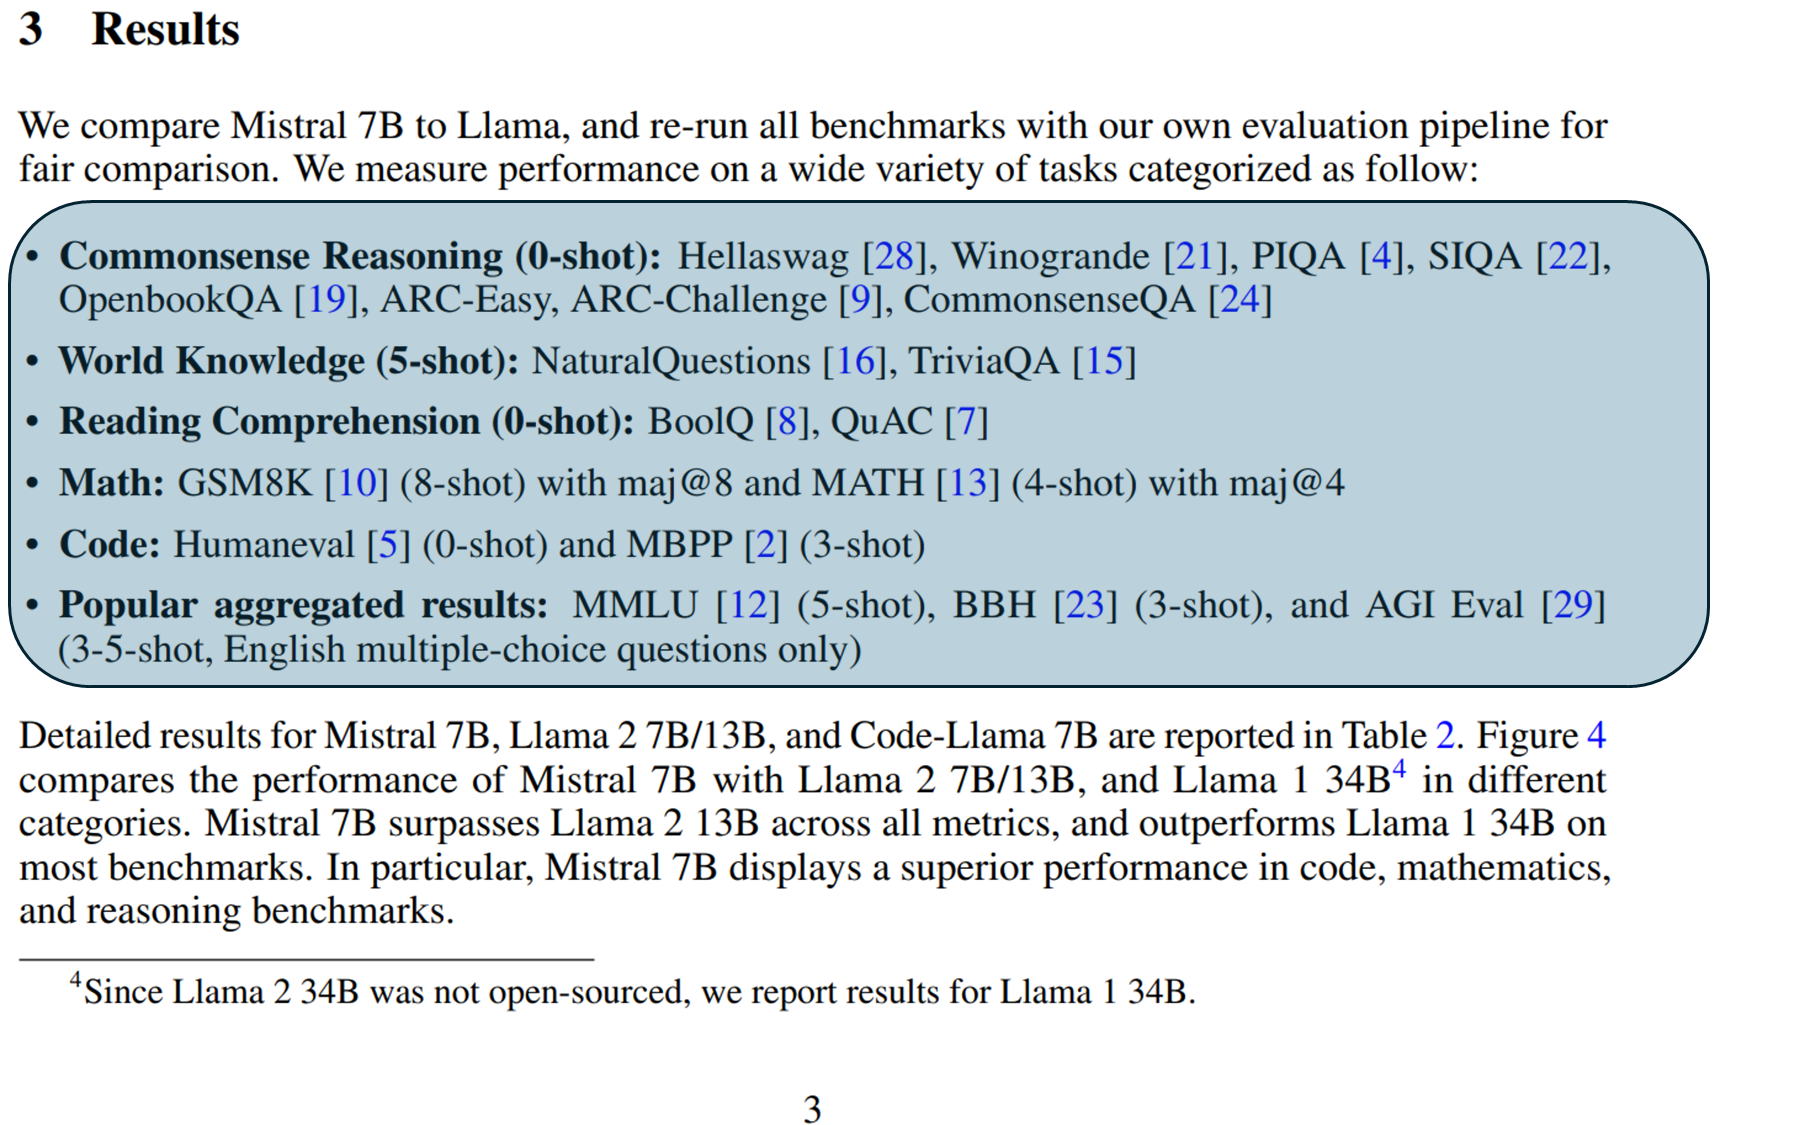

## Comparing to top_k independently

In [ ]:
def topKcandidatesCompare(top_ks, consulta):
    resultados = []
    # Make sure that the top_ks list is passed correctly and is not redefined here.

    for top_k in top_ks:
        # Set the retriever to the current value of top_k.
        retriever = index.as_retriever(similarity_top_k=top_k)

        #  Create a new query engine with the retriever configured.
        query_engine = RetrieverQueryEngine.from_args(retriever, llm=llm)

        # Performs the consultation.
        response = query_engine.query(consulta)

        # Save the result in the results list
        resultados.append({
            "top_k": top_k,
            "text": str(response)
        })

    return resultados

In [ ]:
comparison=topKcandidatesCompare([1,2,3,4,5],"In which task and sub-task categories has performance been measured? Group by task and subtask")

In [ ]:
for item in comparison:
    print('top_k ' + str(item['top_k']) + ' ' + item['text'] +'\n ......................')

top_k 1 Performance has been measured in the task of language understanding and the sub-tasks include multitask language understanding and mathematical problem solving.
 ......................
top_k 2 Performance has been measured in the following task and sub-task categories:  
- Task: Language Understanding  
  - Sub-tasks: MMLU, HellaSwag, WinoG, PIQA, Arc-e, Arc-c, NQ, TriviaQA, HumanEval, MBPP, MATH, GSM8K  
- Task: Chatbot Arena  
  - Sub-task: MT Bench
 ......................
top_k 3 Commonsense Reasoning:
- 0-shot: Hellaswag, Winogrande, PIQA, ARC-Easy, ARC-Challenge, CommonsenseQA

World Knowledge:
- 5-shot: NaturalQuestions, TriviaQA

Reading Comprehension:
- 0-shot: BoolQ, QuAC

Math:
- GSM8K (8-shot) with maj@8
- MATH (4-shot) with maj@4

Code:
- Humaneval (0-shot)
- MBPP (3-shot)
 ......................
top_k 4 Commonsense Reasoning (0-shot): Hellaswag, Winogrande, PIQA, SIQA, OpenbookQA, ARC-Easy, ARC-Challenge, CommonsenseQA
World Knowledge (5-shot): NaturalQuestions, Tr


As we can observe, using a top-k of 4 yields better results than a top-k of 5, since it avoids including the Popular Aggregated results.
This is where it might be interesting to combine a **React Agent with a dynamic top-k tool**. The idea is that the agent iterates until it has enough information to respond in the best way possible

# Agentic Query PipeLine


## Setup Calback Manager

We setup a global callback manager (helps in case you want to plug in downstream observability integrations).

In [ ]:
# define global callback setting
from llama_index.core.settings import Settings
from llama_index.core.callbacks import CallbackManager

callback_manager = CallbackManager()
Settings.callback_manager = callback_manager

## Setup Tool

Now we setup a tool in order to get a dynamic top_k.The concept is for the React agent to progressively increase the top-k and continue observing until it identifies the best result

In [ ]:
#https://docs.llamaindex.ai/en/stable/examples/agent/agent_runner/query_pipeline_agent/
from llama_index.core.query_pipeline import FnComponent
from llama_index.core.tools import BaseTool, FunctionTool

def topKcandidates(top_ks, consulta):
    resultados = []
    # Asegúrate de que la lista top_ks se pasa correctamente y no se redefine aquí.


    # Configura el retriever para el valor actual de top_k.
    # Asegúrate de que 'index' está definido y es accesible aquí.
    retriever = index.as_retriever(similarity_top_k=top_ks)

    # Crea un nuevo query engine con el retriever configurado.
    # Asegúrate de que 'RetrieverQueryEngine' y 'llm' están definidos y son accesibles aquí.
    query_engine = RetrieverQueryEngine.from_args(retriever, llm=llm)

    # Realiza la consulta.
    response = query_engine.query(consulta)

    # Guarda el resultado en la lista de resultados.
    resultados.append({
        "top_k": top_ks,
        "text": str(response)
    })

    # En lugar de guardar en un archivo, retorna la lista directamente.
    return resultados


#topK_tool = FunctionTool.from_defaults(fn=topKcandidates,tool_metadata="Perform {consulta} within an index using different values of top_k. Each query is executed with a different top_k value, allowing comparison of how the obtained results vary as this parameter is adjusted.")
topK_tool = FunctionTool.from_defaults(fn=topKcandidates)
#topK_tool = FunctionTool.from_defaults(fn=topKcandidates,description='topKcandidates tool agent')

## Setup ReAct Agent Pipeline

An agentic query pipeline MUST be Tuple[AgentChatResponse, bool]. You'll see this below.

In [ ]:

from llama_index.core.query_pipeline import QueryPipeline as QP

qp = QP(verbose=True)

### Define Agent Input Component

Here we define the agent input component, called at the beginning of every agent step. Besides passing along the input, we also do initialization/state modification.

In [ ]:
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
    ResponseReasoningStep,
)
from llama_index.core.agent import Task, AgentChatResponse
from llama_index.core.query_pipeline import (
    AgentInputComponent,
    AgentFnComponent,
    CustomAgentComponent,
    QueryComponent,
    ToolRunnerComponent,
)
from llama_index.core.llms import MessageRole
from typing import Dict, Any, Optional, Tuple, List, cast


## Agent Input Component
## This is the component that produces agent inputs to the rest of the components
## Can also put initialization logic here.
def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent input function.

    Returns:
        A Dictionary of output keys and values. If you are specifying
        src_key when defining links between this component and other
        components, make sure the src_key matches the specified output_key.

    """
    # initialize current_reasoning
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

### Define Agent Prompt

Here we define the agent component that generates a ReAct prompt, and after the output is generated from the LLM, parses into a structured object.

In [ ]:
from llama_index.core.agent import ReActChatFormatter
from llama_index.core.query_pipeline import InputComponent, Link
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import BaseTool


system_header_new='''You are trying to generate a proper natural language response given a user input query.This query will be used as input for the topKcandidates tool agent.\n\n## Tools\n\n You are responsible for using this tool to complete the task at hand.\nThis may require breaking the task into subtasks and using this tool to complete each subtask.\n\nYou have access to the  tool:\n{tool_desc}\n\n\n## Output Format\n\nPlease answer in the same language as the question and use the following format:\n\n```\nThought: The current language of the user is: (user\'s language). I need to use the tool to help me answer the question.\nAction: tool name (one of {tool_names}) if using a tool.\nAction Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})\n```\n\nPlease ALWAYS start with a Thought.\n\nPlease use a valid JSON format for the Action Input. Do NOT do this {{\'input\': \'hello world\', \'num_beams\': 5}}.\n\nIf this format is used, the user will respond in the following format:\n\n```\nObservation: tool response\n```\n\nYou should keep repeating the above format and increasing the top_k (starting from top_k=1) till you have enough information to answer the question without using tool again. At that point, you MUST respond in the one of the following two formats:\n\n```\nThought: I can answer without using the tool again. I\'ll use the user\'s language to answer\nAnswer: [your answer here (In the same language as the user\'s question)]\n```\n\n```\nThought: I cannot answer the question with the provided tool.\nAnswer: [your answer here (In the same language as the user\'s question)]\n```\n\n## Current Conversation\n\nBelow is the current conversation consisting of interleaving human and assistant messages.\n'''



system_headerOriginal='''You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\nYou have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.\nThis may require breaking the task into subtasks and using different tools to complete each subtask.\n\nYou have access to the following tools:\n{tool_desc}\n\n\n## Output Format\n\nPlease answer in the same language as the question and use the following format:\n\n```\nThought: The current language of the user is: (user\'s language). I need to use a tool to help me answer the question.\nAction: tool name (one of {tool_names}) if using a tool.\nAction Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})\n```\n\nPlease ALWAYS start with a Thought.\n\nPlease use a valid JSON format for the Action Input. Do NOT do this {{\'input\': \'hello world\', \'num_beams\': 5}}.\n\nIf this format is used, the user will respond in the following format:\n\n```\nObservation: tool response\n```\n\nYou should keep repeating the above format till you have enough information to answer the question without using any more tools. At that point, you MUST respond in the one of the following two formats:\n\n```\nThought: I can answer without using any more tools. I\'ll use the user\'s language to answer\nAnswer: [your answer here (In the same language as the user\'s question)]\n```\n\n```\nThought: I cannot answer the question with the provided tools.\nAnswer: [your answer here (In the same language as the user\'s question)]\n```\n\n## Current Conversation\n\nBelow is the current conversation consisting of interleaving human and assistant messages.\n'''

## define prompt function

def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # Add input to reasoning
    chat_formatter = ReActChatFormatter(system_header=system_header_new)

    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(
    fn=react_prompt_fn, partial_dict={"tools": [topK_tool]}
)

The system prompt has been modified as follows:

In [ ]:
system_header_new

'You are trying to generate a proper natural language response given a user input query.This query will be used as input for the topKcandidates tool agent.\n\n## Tools\n\n You are responsible for using this tool to complete the task at hand.\nThis may require breaking the task into subtasks and using this tool to complete each subtask.\n\nYou have access to the  tool:\n{tool_desc}\n\n\n## Output Format\n\nPlease answer in the same language as the question and use the following format:\n\n```\nThought: The current language of the user is: (user\'s language). I need to use the tool to help me answer the question.\nAction: tool name (one of {tool_names}) if using a tool.\nAction Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})\n```\n\nPlease ALWAYS start with a Thought.\n\nPlease use a valid JSON format for the Action Input. Do NOT do this {{\'input\': \'hello world\', \'num_beams\': 5}}.\n\nIf this format is used, th

The original prompt is the following:

In [ ]:
system_headerOriginal

'You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\nYou have access to a wide variety of tools. You are responsible for using the tools in any sequence you deem appropriate to complete the task at hand.\nThis may require breaking the task into subtasks and using different tools to complete each subtask.\n\nYou have access to the following tools:\n{tool_desc}\n\n\n## Output Format\n\nPlease answer in the same language as the question and use the following format:\n\n```\nThought: The current language of the user is: (user\'s language). I need to use a tool to help me answer the question.\nAction: tool name (one of {tool_names}) if using a tool.\nAction Input: the input to the tool, in a JSON format representing the kwargs (e.g. {{"input": "hello world", "num_beams": 5}})\n```\n\nPlease ALWAYS start with a Thought.\n\nPlease use a valid JSON format for the Action Input. Do NOT do this {{\'input\': \


### Define Agent Output Parser + Tool Pipeline

Once the LLM gives an output, we have a decision tree:

If an answer is given, then we're done. Process the output
If an action is given, we need to execute the specified tool with the specified args, and then process the output.

In [ ]:
from typing import Set, Optional
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.llms import ChatResponse
from llama_index.core.agent.types import Task


def parse_react_output_fn(
    task: Task, state: Dict[str, Any], chat_response: ChatResponse
):
    """Parse ReAct output into a reasoning step."""
    output_parser = ReActOutputParser()
    reasoning_step = output_parser.parse(chat_response.message.content)
    return {"done": reasoning_step.is_done, "reasoning_step": reasoning_step}


parse_react_output = AgentFnComponent(fn=parse_react_output_fn)

def run_tool_fn(task: Task, state: Dict[str, Any], reasoning_step: ActionReasoningStep):
    # Check if the iteration counter exists in the state, if not, initialize it.
    if "iteration_count" not in state:
        state["iteration_count"] = 0



    # Create and configure the tool execution component with the specified tool and callback manager
    tool_runner_component = ToolRunnerComponent([topK_tool], callback_manager=task.callback_manager)

    # Execute the specified tool with the provided input and store the output.
    tool_output = tool_runner_component.run_component(tool_name=reasoning_step.action, tool_input=reasoning_step.action_input)

    # Create a new observation step based on the output of the tool and add it to the current rationale
    observation_step = ObservationReasoningStep(observation=str(tool_output))
    state["current_reasoning"].append(observation_step)


        # Check if 5 or more iterations have already been performed
    if state["iteration_count"] >= 5:
        # If the iteration limit has been reached or exceeded, return the result obtained so far.
        return {"response_str": observation_step.get_content(), "is_done": True}

    # If the iteration limit has not been reached, continue with the process.
    # Increment the iteration counter
    state["iteration_count"] += 1

    #  Return the response string based on the observation and note that the process has not yet been completed.

    return {"response_str": observation_step.get_content(), "is_done": False}

# def run_tool_fn(
#     task: Task, state: Dict[str, Any], reasoning_step: ActionReasoningStep
# ):
#     """Run tool and process tool output."""
#     tool_runner_component = ToolRunnerComponent(
#         [topK_tool], callback_manager=task.callback_manager
#     )
#     tool_output = tool_runner_component.run_component(
#         tool_name=reasoning_step.action,
#         tool_input=reasoning_step.action_input,
#     )
#     observation_step = ObservationReasoningStep(observation=str(tool_output))
#     state["current_reasoning"].append(observation_step)
#     # TODO: get output

#     return {"response_str": observation_step.get_content(), "is_done": False}


run_tool = AgentFnComponent(fn=run_tool_fn)


def process_response_fn(
    task: Task, state: Dict[str, Any], response_step: ResponseReasoningStep
):
    """Process response."""
    state["current_reasoning"].append(response_step)
    response_str = response_step.response
    # Now that we're done with this step, put into memory
    state["memory"].put(ChatMessage(content=task.input, role=MessageRole.USER))
    state["memory"].put(
        ChatMessage(content=response_str, role=MessageRole.ASSISTANT)
    )

    return {"response_str": response_str, "is_done": True}


process_response = AgentFnComponent(fn=process_response_fn)


def process_agent_response_fn(
    task: Task, state: Dict[str, Any], response_dict: dict
):
    """Process agent response."""
    return (
        AgentChatResponse(response_dict["response_str"]),
        response_dict["is_done"],
    )


process_agent_response = AgentFnComponent(fn=process_agent_response_fn)

### Stitch together Agent Query Pipeline


We can now stitch together the top-level agent pipeline: agent_input -> react_prompt -> llm -> react_output.

The last component the model="gpt-4-1106-preview" can be selected

In [ ]:
from llama_index.core.query_pipeline import QueryPipeline as QP
from llama_index.llms.openai import OpenAI

qp.add_modules(
    {
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-3.5-turbo"),
        "react_output_parser": parse_react_output,
        "run_tool": run_tool,
        "process_response": process_response,
        "process_agent_response": process_agent_response,
    }
)

In [ ]:
# link input to react prompt to parsed out response (either tool action/input or observation)
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output_parser"])

# add conditional link from react output to tool call (if not done)
qp.add_link(
    "react_output_parser",
    "run_tool",
    condition_fn=lambda x: not x["done"],
    input_fn=lambda x: x["reasoning_step"],
)
# add conditional link from react output to final response processing (if done)
qp.add_link(
    "react_output_parser",
    "process_response",
    condition_fn=lambda x: x["done"],
    input_fn=lambda x: x["reasoning_step"],
)

# whether response processing or tool output processing, add link to final agent response
qp.add_link("process_response", "process_agent_response")
qp.add_link("run_tool", "process_agent_response")

### Visualize Query Pipeline

In [ ]:
pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network

net = Network(notebook=True,cdn_resources="in_line", directed=True)
#setup output size
net = Network(notebook=True,  height="500px", width="800px",cdn_resources="in_line", directed=True)
net.from_nx(qp.clean_dag)
net.show("agent_dag.html")

agent_dag.html


In many occasions when visualizing in Google Collab the output of the DAG in html can give problems. My recommendation is to execute it in the following way:

In [ ]:
from IPython.core.display import display, HTML
with open("agent_dag.html", "r") as file:
    html_string = file.read()

display(HTML(html_string))

## Run the Agent

In [ ]:
from llama_index.core.agent import QueryPipelineAgentWorker, AgentRunner
from llama_index.core.callbacks import CallbackManager

agent_worker = QueryPipelineAgentWorker(qp)
agent = AgentRunner(
    agent_worker, callback_manager=CallbackManager([]), verbose=True
)

In [ ]:
 #run this e2e
agent.reset()
response = agent.chat(
    "In which task and sub-task categories has performance been measured? Group by task and subtask"
)
#some examples
#"In which task and sub-task categories has performance been measured? Group by task and subtask eg: task1: subtask 1, subtask 2.../n  task2:"
#In which task and sub-task categories has performance been measured? Group by task and subtask eg: task1, subtask 1 subtask 2



> Running step 7d4c90e2-6b52-4557-9814-501baae35a09. Step input: In which task and sub-task categories has performance been measured? Group by task and subtask
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encoding 'cl100k_base'>>, allowed_special='all'), chat_store=SimpleChatSto...
task: task_id='793bd6ff-5443-4acb-bedf-d587ec956db6' input='In which task and sub-task categories has performance been measured? Group by task and subtask' memory=ChatMemoryBuffer(token_limit=3000, tokenize...

> Running module react_prompt with input: 
input: In which task and sub-task categories has performance been measured? Group by task and subtask

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are trying to generate a proper natural language response given a user input query.This query will be used as input for the

In [ ]:
print(response)

Performance has been measured in various task and sub-task categories. Here are some of them:
- Commonsense Reasoning: Hellaswag, Winogrande, PIQA, SIQA, OpenbookQA, ARC-Easy, ARC-Challenge, CommonsenseQA
- World Knowledge: NaturalQuestions, TriviaQA
- Reading Comprehension: BoolQ, QuAC
- Math: GSM8K (8-shot) with maj@8, MATH (4-shot) with maj@4
- Code: Humaneval (0-shot), MBPP (3-shot)
- Popular aggregated results: MMLU (5-shot), BBH (3-shot), AGI Eval (3-5-shot, English multiple-choice questions only)


Using this approach with React and dynamic top-k, we observe that the response is more comprehensive and does not overlook any of the metric categories. That's everything, happy coding